In [1]:
import numpy             as np
import matplotlib.pyplot as plt

from derivGP import JaxDerviativeGP

In [2]:
n  = 20
pn = 50

x = np.random.rand(n)

y = np.exp(-x*2)*np.sin(x*2.*np.pi)

px = np.linspace(0,1,pn)
py = np.exp(-px*2)*np.sin(px*2.*np.pi)

# JaxDerivativeGP with Bayesian inference for correlation length and marginal variance

- To account for uncertainty in these GP hyperparameters, I've set the code up to use numpyro to sample these parameters using HMC. This is pretty fast, not more than 10 or 20 seconds in my toy problems here

- Prediction is currently very slow however. I need to JIT some of the prediction functions to try to speed that up, but right now it is slow to loop through the 4000 samples and sample from the GP for each case.

In [3]:
jgp = JaxDerviativeGP(x, y)
jgp.bayes_train()

/home/mikegros/Projects/JaxGP/derivGP/gp.py:111: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  progress_bar = True,
sample: 100%|██████████| 1500/1500 [00:00<00:00, 1804.64it/s, 3 steps of size 8.61e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  corr_len      1.61      2.01      0.99      0.05      3.52   3068.35      1.00
  marg_var      1.69      2.42      1.04      0.02      3.64   2180.03      1.00

Number of divergences: 0


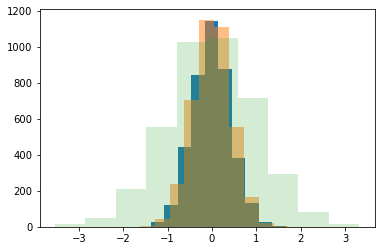

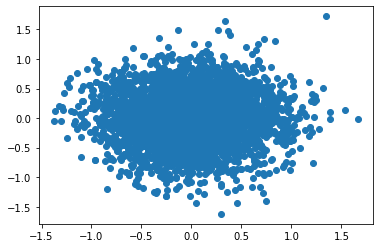

In [4]:
plt.hist(np.log10(np.array(jgp.samples["corr_len"])))
plt.hist(np.log10(np.array(jgp.samples["marg_var"])),alpha=0.5)
plt.hist(np.random.randn(4000), alpha=0.2)
plt.show()

plt.scatter(np.log10(np.array(jgp.samples["corr_len"])), np.log10(np.array(jgp.samples["marg_var"])))


In [4]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px)


CPU times: user 5min 29s, sys: 5.62 s, total: 5min 35s
Wall time: 42.6 s


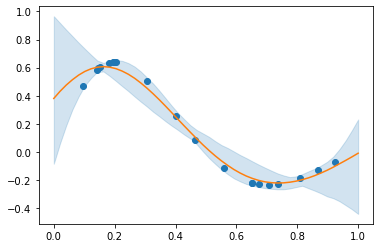

In [5]:
plt.scatter(x, y,c="C0")
plt.plot(px, y_hat, c="C1")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


In [6]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px, derivative="df/dx")


CPU times: user 11min 37s, sys: 10.9 s, total: 11min 48s
Wall time: 1min 28s


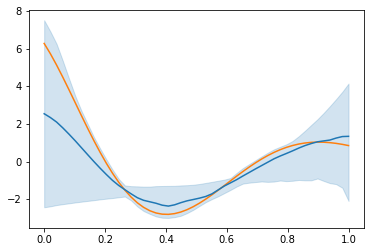

CPU times: user 744 ms, sys: 11.9 ms, total: 756 ms
Wall time: 94.2 ms


In [7]:
%%time
plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()


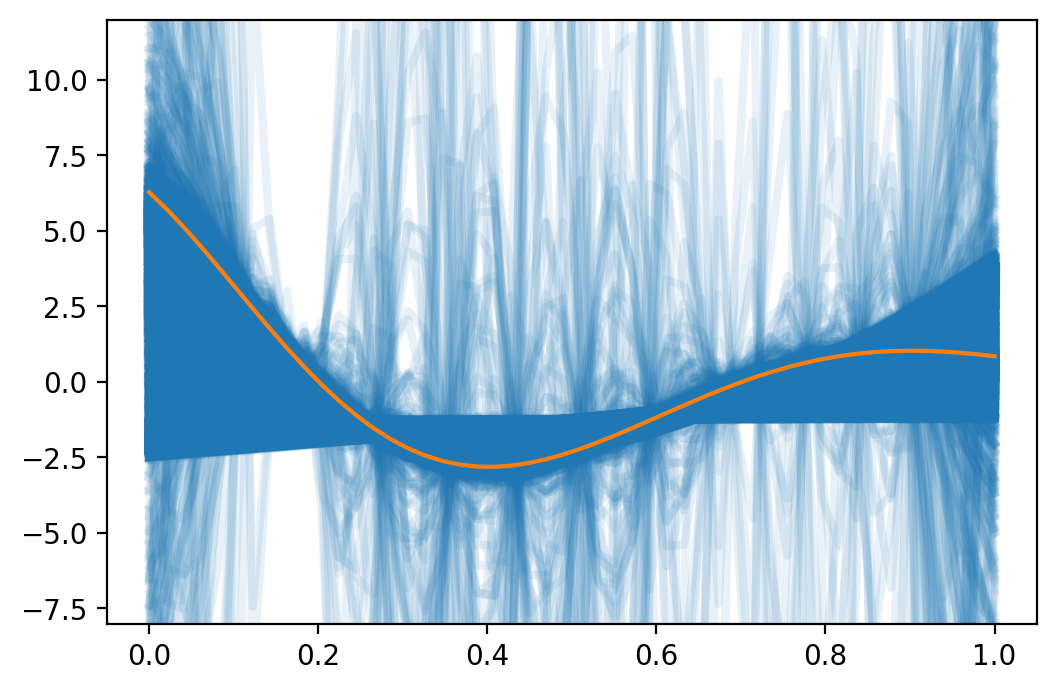

CPU times: user 3.51 s, sys: 40 ms, total: 3.55 s
Wall time: 3.55 s


In [9]:
%%time
plt.figure(dpi=200)
plt.plot(px, preds.T, c="C0", alpha=0.1, linewidth=3)
plt.plot(px, -2*np.exp(-2*px)*np.sin(px*2.*np.pi) + np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi, c="C1")
plt.ylim(-8,12)
plt.show()


In [10]:
%%time
preds, y_hat, lower, upper = jgp.bayes_predict(px, derivative="d2f/dx2")


CPU times: user 35min 18s, sys: 34.9 s, total: 35min 53s
Wall time: 4min 30s


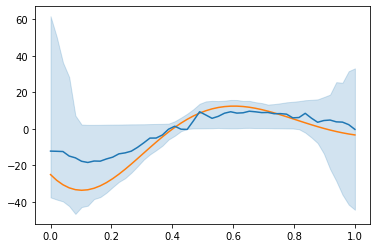

In [11]:
plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")

plt.plot(px, y_hat, c="C0")
plt.fill_between(px, lower, upper, alpha=0.2, color="C0")
plt.show()

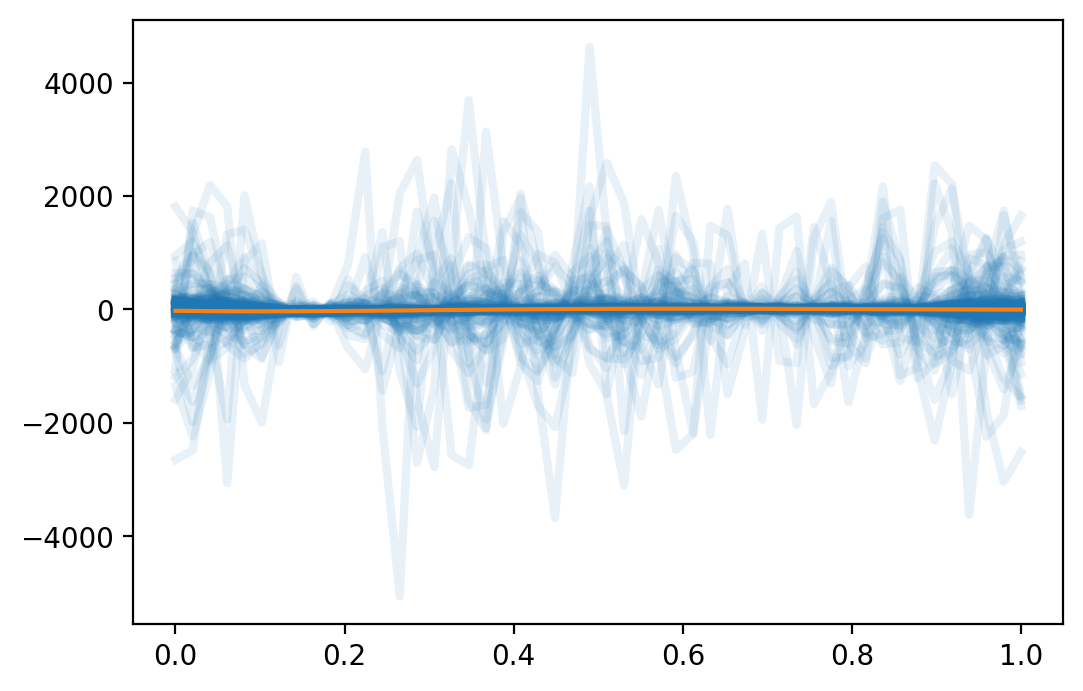

CPU times: user 3.21 s, sys: 20 ms, total: 3.23 s
Wall time: 3.23 s


In [12]:
%%time
plt.figure(dpi=200)
plt.plot(px, preds.T, c="C0", alpha=0.1, linewidth=3)
plt.plot(px, 4*np.exp(-2*px)*np.sin(px*2.*np.pi) + 
         -4*np.pi*np.exp(-2*px)*np.cos(px*2.*np.pi) + 
         -2*np.exp(-2*px)*np.cos(px*2.*np.pi)*2*np.pi - 
         np.exp(-2*px)*np.sin(px*2.*np.pi)*4*np.pi**2, c="C1")
plt.show()


In [2]:
def truef(x):
    return np.sin(x[:,0]*2 *np.pi) + x[:,1]

def truedfdx(x):
    #return -np.sin(x[:,0]*2 *np.pi)*4 *np.pi**2
    return np.cos(x[:,0]*2 *np.pi)*2 *np.pi

def truedfdy(x):
    #return 1.*np.zeros_like(x[:,0])
    return 1.*np.ones_like(x[:,0])


In [3]:
n  = 30
pn = 400

x  = np.random.rand(n,2)
px = np.array([(x, y) for x in np.linspace(0,1,20) for y in np.linspace(0,1,20)])
y  = truef(x)


In [4]:
jgp = JaxDerviativeGP(x, y)


In [5]:
jgp.bayes_train()

/home/mikegros/Projects/JaxGP/derivGP/gp.py:111: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  progress_bar = True,
sample: 100%|██████████| 1500/1500 [00:00<00:00, 1691.30it/s, 3 steps of size 8.61e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  corr_len      1.61      2.01      0.99      0.05      3.52   3058.79      1.00
  marg_var      1.70      2.44      1.04      0.02      3.68   2180.13      1.00

Number of divergences: 0


In [7]:
%%time
py   = truef(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, lower, upper = jgp.bayes_predict(px)


This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 17min 26s, sys: 21.9 s, total: 17min 48s
Wall time: 2min 10s


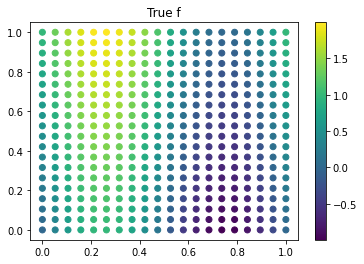

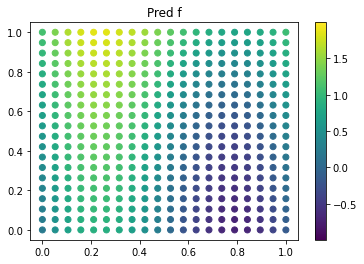

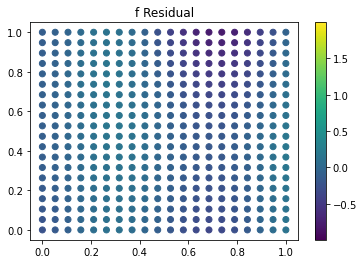

In [8]:
plt.scatter(px[:, 0], px[:, 1], c=py, vmin=vmin, vmax=vmax)
plt.title("True f")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat, vmin=vmin, vmax=vmax)
plt.title("Pred f")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=py - y_hat, vmin=vmin, vmax=vmax)
plt.title("f Residual")
plt.colorbar()
plt.show()


In [9]:
%%time 

py   = truedfdx(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, upper, lower = jgp.bayes_predict(px, derivative="df/dx")

This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.
CPU times: user 28min 37s, sys: 31.6 s, total: 29min 9s
Wall time: 3min 33s


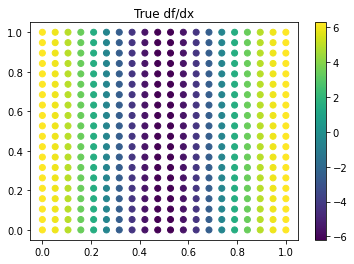

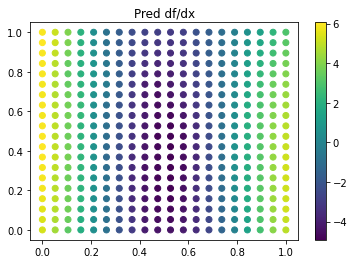

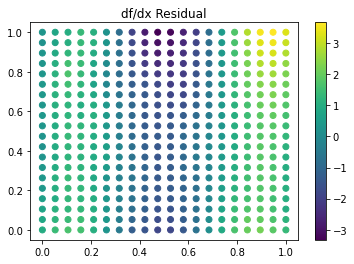

In [10]:
plt.scatter(px[:, 0], px[:, 1], c=py)
plt.title("True df/dx")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat)
plt.title("Pred df/dx")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c= py - y_hat)
plt.title("df/dx Residual")
plt.colorbar()
plt.show()


In [11]:
py   = truedfdy(px)

vmin = np.min(py)
vmax = np.max(py)

preds, y_hat, upper, lower = jgp.bayes_predict(px, derivative="df/dy")

This is currently really slow - 
 a minute or two for predicting 50 points from 4000 samples with 20 observations.
Just a heads up.


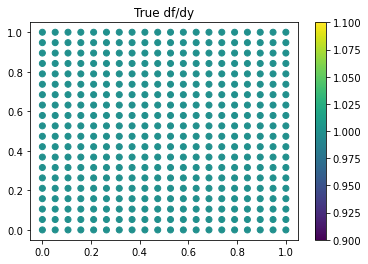

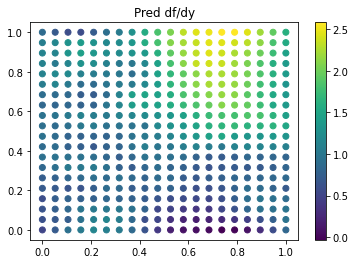

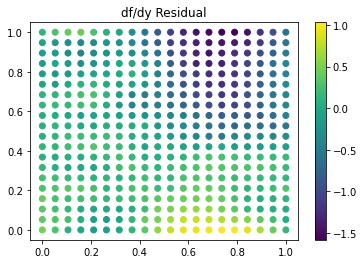

In [12]:
plt.scatter(px[:, 0], px[:, 1], c=py)
plt.title("True df/dy")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=y_hat)
plt.title("Pred df/dy")
plt.colorbar()
plt.show()

plt.scatter(px[:, 0], px[:, 1], c=py - y_hat)
plt.title("df/dy Residual")
plt.colorbar()
plt.show()
